# StateFarm Kaggle Competition

https://www.kaggle.com/c/state-farm-distracted-driver-detection

In [47]:
#Data
#79726 Test Images
#22425 Train Images
#26 Drivers (in training set)
#10 Class labels

In [48]:
#Verify we are in the lesson3 directory
%pwd

u'/home/ubuntu/deep_learning_course/lesson3'

In [49]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/statefarm'
METADATA_FILENAME = 'driver_imgs_list.csv'

In [50]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

In [51]:
def make_dir_if_not_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

In [52]:
%mkdir $DATA_HOME_DIR/valid
%mkdir $DATA_HOME_DIR/results
%mkdir $DATA_HOME_DIR/models
%mkdir -p $DATA_HOME_DIR/test/unknown
%mkdir -p $DATA_HOME_DIR/sample/models
%mkdir -p $DATA_HOME_DIR/sample/train
%mkdir -p $DATA_HOME_DIR/sample/test
%mkdir -p $DATA_HOME_DIR/sample/valid
%mkdir -p $DATA_HOME_DIR/sample/results

# Setup Validation/Sample Sets

In [53]:
from glob import glob
import numpy as np
from shutil import copyfile
from random import randrange

In [54]:
def get_lines_from_file(filename):
    fileobj = open(os.path.join(DATA_HOME_DIR,filename),'r')
    headers = fileobj.readline()
    #Read lines into file without '\n'
    lines = fileobj.read().splitlines()
    fileobj.close()   
    return lines

In [55]:
def get_shuffled_images_by_person_and_class():
    lines = get_lines_from_file(METADATA_FILENAME)
    image_dict = {}
    for line in lines:
        subject,classlabel,filename = line.split(",")
        if subject not in image_dict:
            image_dict[subject] = {}
        if classlabel not in image_dict[subject]:
            image_dict[subject][classlabel] = [] #files array
        image_filenames = image_dict[subject][classlabel]
        #Randomly insert the new filename
        image_filenames.insert(randrange(len(image_filenames)+1), filename)
    return image_dict

images = get_shuffled_images_by_person_and_class()
print images['p002'].keys()

VALIDATION_SET_DRIVERS=['p002','p012','p014']
def create_validation_set_from_out_of_sample_drivers():
    '''
    Since the real-life test set will be different drivers
    Let's create a validation set of different drivers too!
    '''
    images = get_shuffled_images_by_person_and_class()
    for driver in VALIDATION_SET_DRIVERS:
        print "DRIVER="+driver
        for classlabel in images[driver].keys():
            print "CLASS="+classlabel
            make_dir_if_not_exists(DATA_HOME_DIR+'/valid/'+classlabel)
            train_filepath = DATA_HOME_DIR+'/train/'+classlabel+'/'
            valid_filepath = DATA_HOME_DIR+'/valid/'+classlabel+'/'
            for filename in os.listdir(train_filepath):
                if filename in images[driver][classlabel]:
                    os.rename(train_filepath+filename, valid_filepath+filename)
                    

create_validation_set_from_out_of_sample_drivers()

['c9', 'c8', 'c3', 'c2', 'c1', 'c0', 'c7', 'c6', 'c5', 'c4']
DRIVER=p002
CLASS=c9
CLASS=c8
CLASS=c3
CLASS=c2
CLASS=c1
CLASS=c0
CLASS=c7
CLASS=c6
CLASS=c5
CLASS=c4
DRIVER=p012
CLASS=c9
CLASS=c8
CLASS=c3
CLASS=c2
CLASS=c1
CLASS=c0
CLASS=c7
CLASS=c6
CLASS=c5
CLASS=c4
DRIVER=p014
CLASS=c9
CLASS=c8
CLASS=c3
CLASS=c2
CLASS=c1
CLASS=c0
CLASS=c7
CLASS=c6
CLASS=c5
CLASS=c4


In [56]:
#Move representative sample of training images from /train to /valid
#20183 Training images (90%)
#2242 Validation Images (10%)
#26 Drivers
#10 Class labels
#86 images per driver
#8 images per class label per driver

#Organize images into classlabels and subjects randoming shuffling them simultanously
def get_shuffled_images_by_class_and_person(input_filename):
    lines = get_lines_from_file(METADATA_FILENAME)
    image_dict = {}
    for line in lines:
        subject,classlabel,filename = line.split(",")
        if classlabel not in image_dict:
            image_dict[classlabel] = {}
        if subject not in image_dict[classlabel]:
            image_dict[classlabel][subject] = []
        image_list = image_dict[classlabel][subject]
        image_list.insert(randrange(len(image_list)+1), filename)

 
    return image_dict

def create_driver_distributed_validation_set():
    '''
    Move 8 images per category per subject from /train to /valid
    Images are pre-shuffled inside each filename array
    This technique avoids bias toward drivers who have way more images than others
    '''
    VALIDATION_IMAGES_PER_DRIVER=8
    images = get_shuffle_images_by_class_and_person(METADATA_FILENAME)
    
    for classlabel in images.keys():
        make_dir_if_not_exists(DATA_HOME_DIR+'/valid/'+classlabel)
        for subject in images[classlabel].keys():
            for i in range(VALIDATION_IMAGES_PER_DRIVER):
                img_filename = images[classlabel][subject][i]
                train_filepath = DATA_HOME_DIR+'/train/'+classlabel+'/'+img_filename
                valid_filepath = DATA_HOME_DIR+'/valid/'+classlabel+'/'+img_filename
                os.rename(train_filepath, valid_filepath)

#create_driver_distributed_validation_set()

In [57]:
# Old way just randomly moving over 8 images per classlabel   
#def create_driver_distributed_validation_set():
#    print "classlabel: "+classlabel
#    make_dir_if_not_exists(DATA_HOME_DIR+'/valid/'+classlabel)
#    g = glob(DATA_HOME_DIR+'/train/'+classlabel+'/*.jpg')
#    shuffled_filepaths = np.random.permutation(g)
#    for i in range(VALIDATION_IMAGES_PER_DRIVER): 
#        print shuffled_filepaths[i]
#        filename = shuffled_filepaths[i].split("/")[-1]
#        print filename
#        new_filepath = DATA_HOME_DIR+'/valid/'+classlabel+'/'+filename
#        os.rename(shuffled_filepaths[i], new_filepath)

In [58]:
#Create class subdirectories in sample/train and sample/valid
class_directory_names = [x[1] for x in os.walk(DATA_HOME_DIR+'/train')][0]

for class_name in class_directory_names:
    make_dir_if_not_exists(DATA_HOME_DIR+'/sample/train/'+class_name)
    make_dir_if_not_exists(DATA_HOME_DIR+'/sample/valid/'+class_name)

In [59]:
#Method to copy random files from one dir to another
def copy_random_files(current_dir, target_dir, count, file_ext):
    g = glob(current_dir+'/*.'+file_ext)
    shuffled_filename_paths = np.random.permutation(g)
    for i in range(count): 
        filename = shuffled_filename_paths[i].split('/')[-1]   
        copyfile(shuffled_filename_paths[i], target_dir+'/'+filename)
    
#copy_random_files(DATA_HOME_DIR+'/train/c0',
#                  DATA_HOME_DIR+'/sample/train/c0',
#                  200,'jpg')

In [60]:
#Copy Training Images To Sample/Train
SAMPLE_TRAIN_COUNT=200 #per c0,c1,c2... directory
for class_name in class_directory_names:
    current_filepath = DATA_HOME_DIR+'/train/'+class_name
    new_filepath = DATA_HOME_DIR+'/sample/train/'+class_name
    copy_random_files(current_filepath, new_filepath, SAMPLE_TRAIN_COUNT, 'jpg')

In [61]:
#Copy Valid Images To Sample/Valid
SAMPLE_VALID_COUNT=50 #per c0,c1,c2... directory
for class_name in class_directory_names:
    current_filepath = DATA_HOME_DIR+'/valid/'+class_name
    new_filepath = DATA_HOME_DIR+'/sample/valid/'+class_name
    copy_random_files(current_filepath, new_filepath, SAMPLE_VALID_COUNT, 'jpg')

In [118]:
#Set Paths - Sample or Prod
root = DATA_HOME_DIR+'/sample' #or nothing
test_path = root + '/test/'
results_path = root + '/results/'
train_path = root + '/train/'
valid_path = root + '/valid/'
models_path = root + '/models/'

In [64]:
from random import shuffle
def get_filenames_in_dir(directory_name):
    for root, dirs, files in os.walk(directory_name):
        return files

def get_random_filename_in_dir(directory_name):
    filenames = get_filenames_in_dir(directory_name)
    shuffle(filenames)
    return filenames[0]

#print get_filenames_in_dir(test_path)
print get_random_filename_in_dir(test_path)

img_96474.jpg


# Explore Some Images!

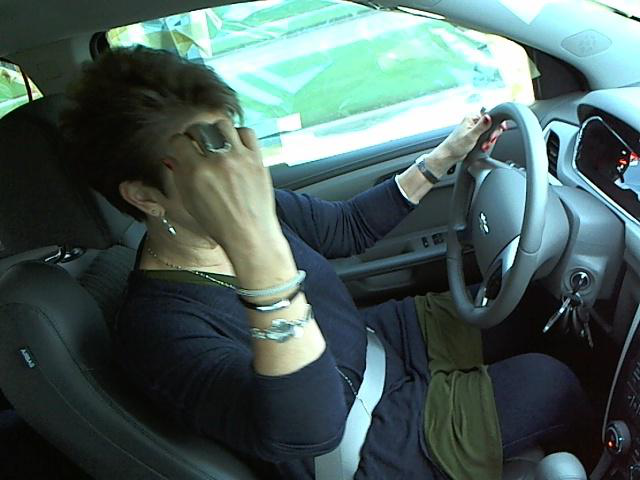

In [74]:
#Explore single image!
from PIL import Image

Image.open(os.path.join(test_path,get_random_filename_in_dir(test_path)))

In [97]:
from keras.preprocessing import image
from utils.utils import plots

#Count of images to visualize
NUM_IMAGES_TO_VIEW=3

#Plot images by index in directory
def plots_images_by_index(indicies_array, directory_path, titles=None):
    filenames = get_filenames_in_dir(directory_path)
    plots([image.load_img(directory_path + filenames[i]) for i in indicies_array],
          titles=titles)

[6, 14, 19]


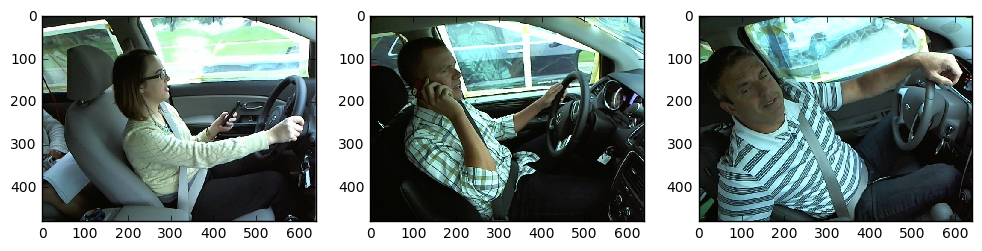

In [100]:
from random import randint
random_indices = [randint(0,25) for i in range(NUM_IMAGES_TO_VIEW)]
print random_indices

#plot some test images
plots_images_by_index(random_indices,test_path)

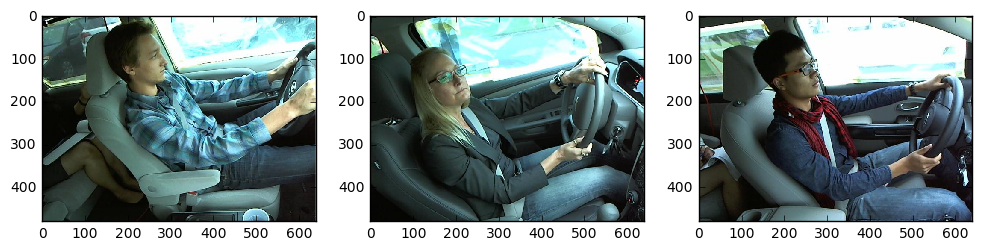

In [101]:
#Plot some training images
plots_images_by_index(random_indices,train_path+'c0/')

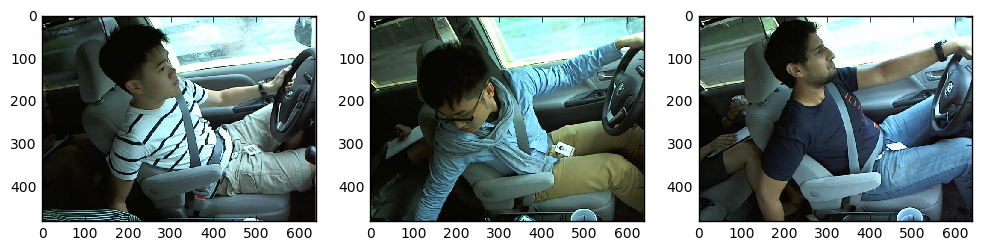

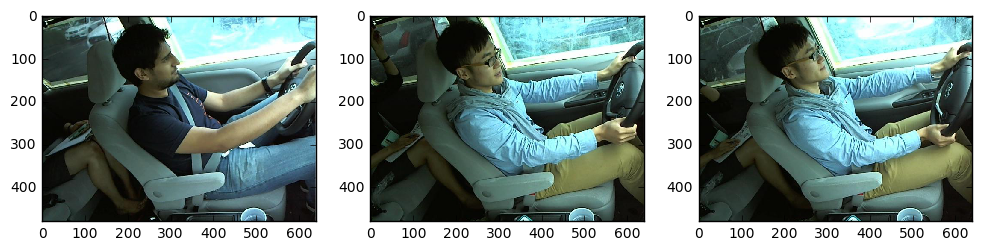

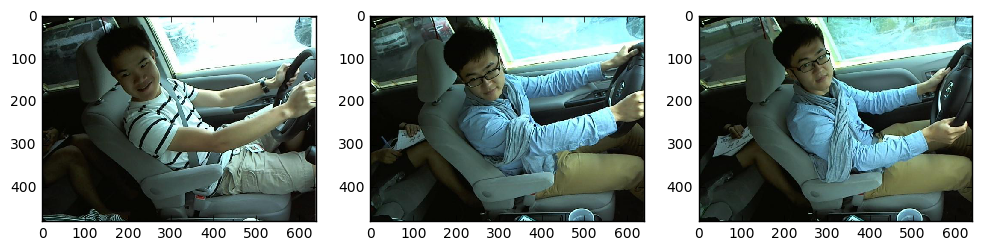

In [102]:
#Plot some validation images
plots_images_by_index(random_indices,valid_path+'c7/')
plots_images_by_index(random_indices,valid_path+'c0/')
plots_images_by_index(random_indices,valid_path+'c9/')

# Build our Model

In [135]:
#import modules
from utils.utils import *
from utils.vgg16 import Vgg16

vgg = Vgg16()

#Set constants
#You can experiment with no_of_epochs to improve the model
BATCH_SIZE=25
NUM_OF_EPOCHS=1
LEARNING_RATE=0.01

vgg.model.summary()

MemoryError: 

In [114]:
#Get Training and Validation Batches
#Use batch size of 1 since we're just doing preprocessing on the CPU
train_batches = get_batches(train_path, shuffle=False, batch_size=1)
val_batches = get_batches(valid_path, shuffle=False, batch_size=1)

Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [115]:
#Get Train/Validation Data Out of Batches
trn_data = get_data(train_batches)
val_data = get_data(val_batches)

print trn_data.shape
print val_data.shape

In [119]:
#Save extracted model data
save_array(models_path + 'train_data.bc', trn_data)
save_array(models_path + 'valid_data.bc', val_data)

In [121]:
# Example of how to load model from file
train_data = load_array(models_path+'train_data.bc')
valid_data = load_array(models_path+'valid_data.bc')

In [127]:
train_classes = batches.classes
valid_classes = val_batches.classes

print train_classes.shape
print valid_classes.shape

(2000,)
(500,)


In [128]:
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [133]:
train_labels = onehot(train_classes)
valid_labels = onehot(valid_classes)

print train_labels.shape
print valid_labels.shape

print valid_labels[:3]

(2000, 10)
(500, 10)
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [111]:
#Let's remove the last Dense layer (linear with softmax) and retrain
model = vgg.model
model.summary()
model.pop()
for layer in model.layers: 
    layer.trainable=False

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

In [112]:
#And add our own Dense Layer (10 = number of state farm class labels)
model.add(Dense(10, activation='softmax'))

In [113]:
#Notice finetune does the same thing, but sets to 1000 output class labels
??vgg.finetune

In [106]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [107]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(NUM_OF_EPOCHS):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
2000/2000 [==============================] - 933s - loss: 14.4152 - acc: 0.0980 - val_loss: 14.5063 - val_acc: 0.1000
Completed 1 fit operations
